In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import pickle

calibration_file = "camera_cal/calibration.p"

%matplotlib inline

In [2]:
def camera_calibration(image_path_mask):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(8,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Make a list of calibration images
    images = glob.glob(image_path_mask)
    images_pbar = tqdm(images, 'Calibrating', unit='images')

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images_pbar):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    return objpoints, imgpoints

In [3]:
# Calibrate camera
objpoints, imgpoints = camera_calibration('camera_cal/calibration*.jpg')

img = cv2.imread('camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# Save the camera calibration result for later use
calibration = {}
calibration["mtx"] = mtx
calibration["dist"] = dist
pickle.dump(calibration, open(calibration_file, "wb"))
print('Calibartion results are stored')


Calibrating: 100%|█████████████████████████| 20/20 [00:08<00:00,  2.34images/s]


Calibartion results are stored


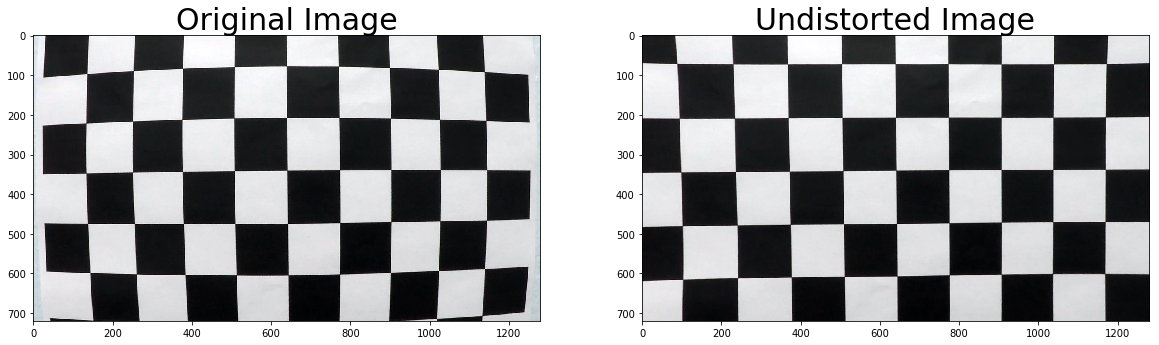

In [4]:
with open(calibration_file, mode='rb') as f:
    calibration = pickle.load(f)

# Test undistortion on an image
img = cv2.imread('camera_cal/calibration1.jpg')

mtx = calibration["mtx"] 
dist = calibration["dist"]

dst = cv2.undistort(img, mtx, dist, None, mtx)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

In [5]:
# Globals
img_size = (1280, 720)

# Points on original image
src = np.float32(
    #Top point of left lane marking line
    [[(img_size[0] / 2) - 50, img_size[1] / 2 + 90],
    #Bottom point of left lane marking line
    [img_size[0] / 5, img_size[1]],
    #Bottom point of left lane marking line
    [(img_size[0] * 5 / 6) + 50, img_size[1]],
    #Top point of left lane marking line
    [(img_size[0] / 2 + 60), img_size[1] / 2 + 90]])
# Points on transformed image
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

M = cv2.getPerspectiveTransform(src, dst)

Minv = np.linalg.inv(M)
nwindows = 9
max_diff = 0.0006
max_prev_diff = 0.00035
min_curve_arg = 1e-04
max_fail_iterations = 3
min_distance_threshold = 1.5 #1.5 meters

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
font = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText1 = (30, 50)
bottomLeftCornerOfText2 = (30, 100)
fontScale = 2
fontColor = (255,255,255)


In [6]:
# Class Line
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # x values of the last n fits of the line
        self.recent_yfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = 2
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []  
        #y values for detected line pixels
        self.ally = []
    
    def build_pixels(self, x, y):
        self.recent_xfitted = x
        self.recent_yfitted = y
        self.allx.append(x)
        self.ally.append(y)    
        return
    
    def get_x_pixels(self):
        return np.array(self.allx).reshape(-1)
        
    def get_y_pixels(self):
        return np.array(self.ally).reshape(-1)
    
    def reset(self):
        self.allx = []
        self.ally = []


In [7]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobel = np.sqrt(np.power(sobelx, 2) + np.power(sobely, 2))
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1    
    
    return mag_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    dir = np.arctan2(abs_sobely, abs_sobelx)
    dir_binary = np.zeros_like(dir)
    dir_binary[(dir >= thresh[0]) & (dir <= thresh[1])] = 1    
    return dir_binary

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold gray 
    g_binary = np.zeros_like(gray)
    g_binary[(gray > 180) & (gray <= 255)] = 1
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
        
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[((s_binary == 1) & (g_binary == 1)) | (sxbinary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined_binary

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


In [8]:
# Load calibration results (undependetly from another cell above to test images)
with open(calibration_file, mode='rb') as f:
    calibration = pickle.load(f)

mtx = calibration["mtx"] 
dist = calibration["dist"]

images = glob.glob('test_images/*.jpg')
for idx, fname in enumerate(images):
    name = fname.split('\\')[1].split('.')
    image = mpimg.imread(fname)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    mpimg.imsave('output_images/' + name[0] + '_u.' + name[1], undist)
    result = pipeline(image)
    mpimg.imsave('output_images/' + name[0] + '_p.' + name[1], result, cmap='gray')


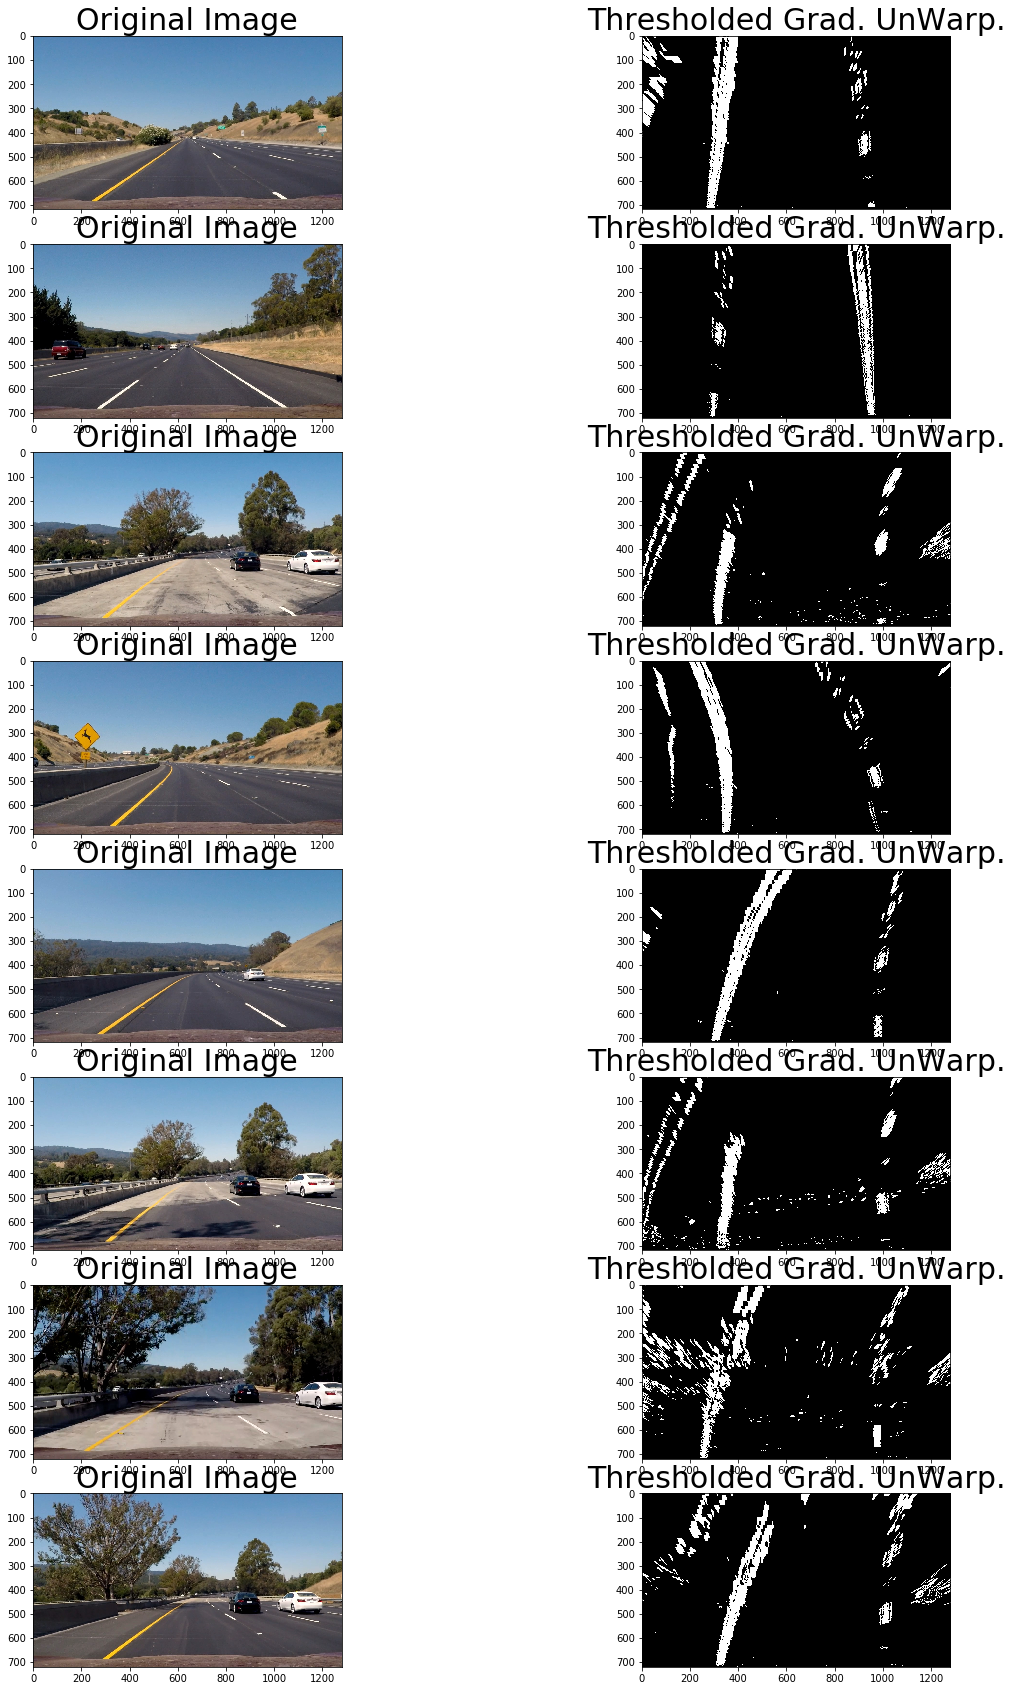

In [9]:
images = glob.glob('test_images/*.jpg')

f, axes = plt.subplots(len(images), 2, figsize=(20, 30))

for idx, fname in enumerate(images):
    name = fname.split('\\')[1].split('.')
    image = mpimg.imread(fname)
    result = pipeline(image)
    undist = cv2.undistort(result, mtx, dist, None, mtx)
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    mpimg.imsave('output_images/' + name[0] + '_out.' + name[1], warped, cmap='gray')
    axes[idx][0].imshow(image)
    axes[idx][0].set_title('Original Image', fontsize=30)
    axes[idx][1].imshow(warped, cmap='gray')
    axes[idx][1].set_title('Thresholded Grad. UnWarp.', fontsize=30)


In [12]:
'''
Basic function to process one video frame (image)
'''
def process_frame(image):
    global startedFromScratch
    global maxErrors
    global fail_iterations
    global iteration
    
    iteration = iteration + 1
    
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    img_size = (image.shape[1], image.shape[0])
    warped = cv2.warpPerspective(undist, M, img_size, flags=cv2.INTER_LINEAR)
    
    binary_warped = pipeline(warped)
    
    if len(binary_warped.shape) > 2:
        binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
    
    ysize = binary_warped.shape[0]
    xsize = binary_warped.shape[1]
    #Define maximal extensions to detect lane markings
    left_bottom = [200, ysize]
    right_bottom = [xsize - 200, ysize]
    left_top = [200, 0]
    right_top = [xsize - 200, 0]
    vertices = np.array([[(left_bottom[0], left_bottom[1]), 
                          (left_top[0], left_top[1]), 
                          (right_top[0], right_top[1]),
                          (right_bottom[0], right_bottom[1])]], dtype=np.int32)
    
    binary_warped = region_of_interest(binary_warped, vertices)
    
    # Previous N Frames were unsuccessfully - start from scratch
    if startedFromScratch == True or maxErrors == True:
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    else:
        leftx_base = left_line.bestx
        rightx_base = right_line.bestx
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    left_x = []
    left_y = []
    right_x = []
    right_y = []
    found = False
    #Loop of attempts to detect at least some pixels on left and right sides
    while found == False:
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        # Extract line pixel positions
        left_x = nonzerox[left_lane_inds]
        left_y = nonzeroy[left_lane_inds]
        right_x = nonzerox[right_lane_inds]
        right_y = nonzeroy[right_lane_inds]
    
        if len(left_x) != 0 and len(left_y) != 0 and len(right_x) != 0 and len(right_y) != 0:
            found = True
            break
        
        #Position is wrong - reset to histogram
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:, :], axis=0)
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_current = np.argmax(histogram[:midpoint])
        rightx_current = np.argmax(histogram[midpoint:]) + midpoint
        #Set to True to avoid endless loop
        found = True
        
    #Not found
    if found == False:
        fail_iterations = fail_iterations + 1
        left_line.detected = False
        right_line.detected = False
        return undist
    
    # Fit a second order polynomial
    left_current_fit = np.polyfit(left_y, left_x, 2)
    right_current_fit = np.polyfit(right_y, right_x, 2)
    #Build pixel arrays
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_current_fit[0]*ploty**2 + left_current_fit[1]*ploty + left_current_fit[2]
    right_fitx = right_current_fit[0]*ploty**2 + right_current_fit[1]*ploty + right_current_fit[2]
    #Evaluate radiuses of curvature
    #Evaluate radiuses of curvature
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(left_y*ym_per_pix, left_x*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_y*ym_per_pix, right_x*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Parallelism difference
    parallel_diff = np.abs(np.subtract(left_current_fit[0], right_current_fit[0]))
    diff = np.subtract(right_fitx, left_fitx)*xm_per_pix
    #Minimal distance between two lines
    min_distance = np.amin(diff)
    
    #Check, whether both functions have the same figure, otherwise - set to max
    #Only for enough curved lines
    if min_distance < min_distance_threshold:
        parallel_diff = max_diff
    else:
        if abs(left_current_fit[0]) > min_curve_arg and abs(right_current_fit[0]) > min_curve_arg:  
            if (left_current_fit[0] < 0 and right_current_fit[0] > 0) or (left_current_fit[0] > 0 and right_current_fit[0] < 0):
                parallel_diff = max_diff
    
    #Previous diff
    if startedFromScratch == False:
        left_prev_diff = np.abs(np.subtract(left_line.current_fit[0], left_current_fit[0]))
        right_prev_diff = np.abs(np.subtract(right_line.current_fit[0], right_current_fit[0]))
    else:
        left_prev_diff = 0
        right_prev_diff = 0
    
    #Sanity check
    if parallel_diff < max_diff and left_prev_diff < max_diff and right_prev_diff < max_diff:
        # Check is successful
        left_line.current_fit = left_current_fit
        right_line.current_fit = right_current_fit
        left_line.bestx = leftx_current
        right_line.bestx = rightx_current
        left_line.build_pixels(left_fitx, ploty)
        right_line.build_pixels(right_fitx, ploty)
        left_line.detected = True
        right_line.detected = True
        fail_iterations = 0
        startedFromScratch = False
    else:
        if startedFromScratch == True:
            #No success before - generate some batch of data
            #Go from bottom to top until distance is more than minimal
            
            #First - reverse arrays to fo from bottom
            rev_left_fitx = np.flipud(left_fitx)
            rev_right_fitx = np.flipud(right_fitx)
            #Condition - minimal distance
            condition = np.subtract(rev_right_fitx, rev_left_fitx) >= min_distance_threshold
            #Extract sub arrays
            left_fitx = np.extract(condition, rev_left_fitx)
            right_fitx = np.extract(condition, rev_right_fitx)
            #Arrange y-values
            ploty = np.flipud(ploty)[:len(left_fitx)]
            
            #Set status like successful
            left_line.current_fit = left_current_fit
            right_line.current_fit = right_current_fit
            left_line.bestx = leftx_current
            right_line.bestx = rightx_current
            left_line.build_pixels(left_fitx, ploty)
            right_line.build_pixels(right_fitx, ploty)
            left_line.detected = True
            right_line.detected = True
            fail_iterations = 0
            startedFromScratch = False
        else:        
            fail_iterations = fail_iterations + 1
            left_fitx = left_line.recent_xfitted
            right_fitx = right_line.recent_xfitted
            #y-dimension must be the same
            ploty = left_line.recent_yfitted
            left_line.detected = False
            right_line.detected = False
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = warp_zero #np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    if len(left_fitx) > 0 and len(right_fitx) > 0: 
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
     
        #Define average curve radius
        curverad = np.average([left_curverad, right_curverad])
        #Define position by getting average between last elements of array (most bottom position)
        left_pos = left_fitx[-1]
        right_pos = right_fitx[-1]
        vehicle_pos = xsize / 2 - np.average([left_pos, right_pos]) 
        if (vehicle_pos < 0):
            pos_text = 'left of center'
        else:
            pos_text = 'right of center'
        pos_text = 'Vehicle is ' + "{:.2f}".format(abs(vehicle_pos) * xm_per_pix) + 'm ' + pos_text
        
        # Draw the lane onto t  he warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
        cv2.putText(undist, 'Radius of curvature = ' + "{:.2f}".format(curverad) + ' (m)', bottomLeftCornerOfText1, font, fontScale, fontColor, 2)
        cv2.putText(undist, pos_text, bottomLeftCornerOfText2, font, fontScale, fontColor, 2)
     
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    if fail_iterations >= max_fail_iterations:
        maxErrors = True
        left_line.reset()
        right_line.reset()
    
    return result


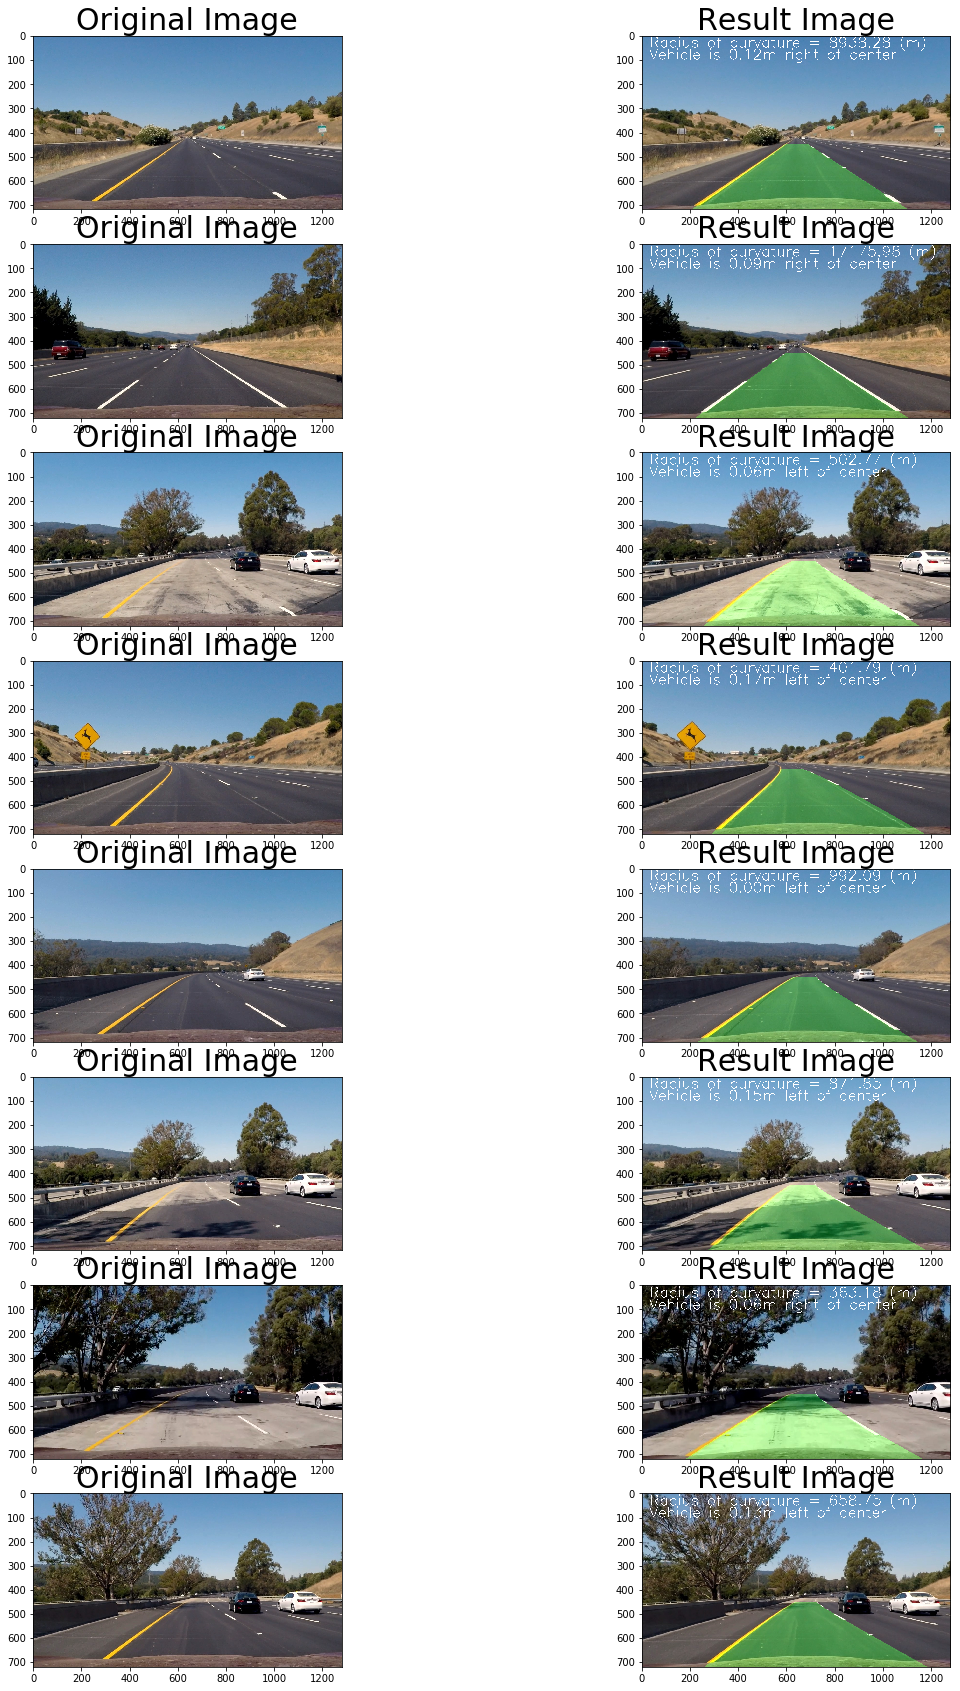

In [13]:
images = glob.glob('test_images/*.jpg')
f, axes = plt.subplots(len(images), 2, figsize=(20, 30))

for idx, fname in enumerate(images):
    name = fname.split('\\')[1].split('.')
    image = mpimg.imread(fname)
    left_line = Line()
    right_line = Line()
    startedFromScratch = True
    maxErrors = False
    fail_iterations = 0
    iteration = 0
    out_image = process_frame(image)
    mpimg.imsave('output_images/' + name[0] + '_res.' + name[1], out_image)
    axes[idx][0].imshow(image)
    axes[idx][0].set_title('Original Image', fontsize=30)
    axes[idx][1].imshow(out_image)
    axes[idx][1].set_title('Result Image', fontsize=30)
    

In [14]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
output = 'output_videos/project_video.mp4'
left_line = Line()
right_line = Line()

startedFromScratch = True
maxErrors = False
fail_iterations = 0
iteration = 0

in_clip = VideoFileClip("project_video.mp4")
out_clip = in_clip.fl_image(process_frame) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [10:27<00:00,  2.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 10min 29s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [16]:
c_output = 'output_videos/challenge_video.mp4'
left_line = Line()
right_line = Line()

startedFromScratch = True
maxErrors = False
fail_iterations = 0
iteration = 0

in_c_clip = VideoFileClip("challenge_video.mp4")
out_c_clip = in_c_clip.fl_image(process_frame) 
%time out_c_clip.write_videofile(c_output, audio=False)

[MoviePy] >>>> Building video output_videos/challenge_video.mp4
[MoviePy] Writing video output_videos/challenge_video.mp4


100%|████████████████████████████████████████| 485/485 [03:47<00:00,  2.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/challenge_video.mp4 

Wall time: 3min 48s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(c_output))